In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(bind=engine)

In [8]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

most_recent_date

('2017-08-23',)

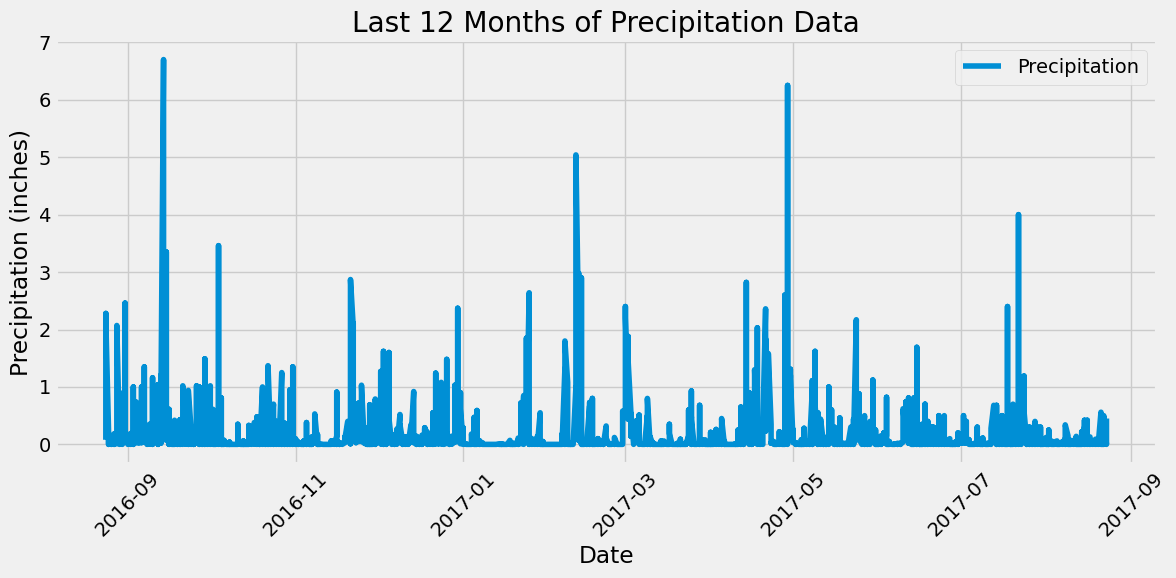

In [22]:
most_recent_date_obj = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date_obj - dt.timedelta(days=365)
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= one_year_ago).all()

precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation']).dropna()
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')
precipitation_df.set_index('date', inplace=True)
precipitation_df.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(precipitation_df.index, precipitation_df['precipitation'], label='Precipitation')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)')
ax.set_title('Last 12 Months of Precipitation Data')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
station_count

9

In [26]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

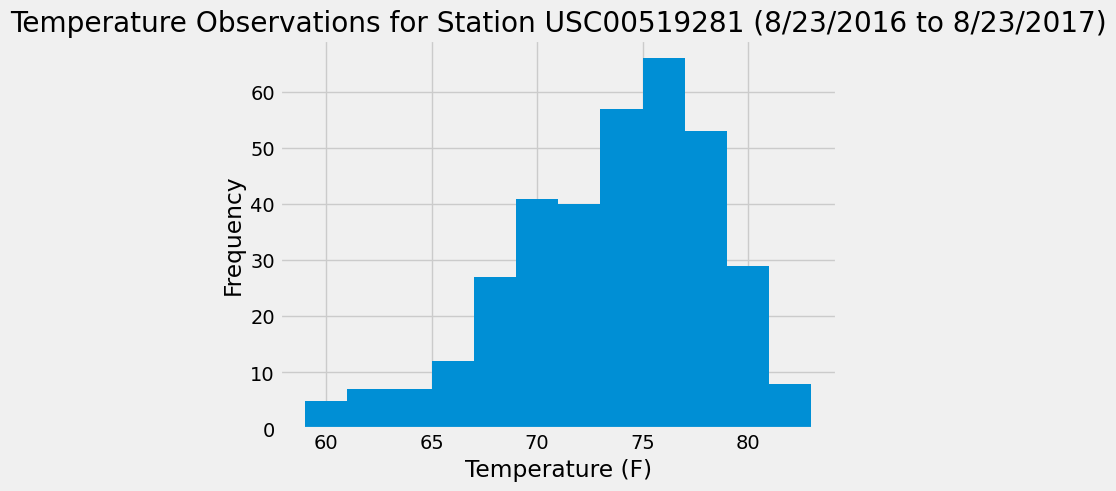

In [28]:
# Query the last 12 months of temperature observation data for the most active station
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-08-23').all()

# Create a list of temperature observations from the query results
temperatures = [result[0] for result in results]

# Plot the results as a histogram
plt.hist(temperatures, bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Observations for Station USC00519281 (8/23/2016 to 8/23/2017)")
plt.show()


# Close Session

In [29]:
# Close Session
session.close()